In [4]:
from bs4 import BeautifulSoup
import requests
import time
import pandas as pd
import re
import string
from nltk.corpus import stopwords
from nltk import word_tokenize
from nltk.stem import WordNetLemmatizer 
import gensim
import csv
import json
import nltk
from gensim import corpora, models

In [5]:
nltk.download("stopwords")
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\asus\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.132 Safari/537.36"}
source = requests.get('https://www.imdb.com/chart/moviemeter?sort=ir,desc&mode=simple&page=1', headers = headers).text

In [8]:
soup = BeautifulSoup(source, 'html.parser')

In [9]:
print(soup.prettify())

<!DOCTYPE html>
<html xmlns:fb="http://www.facebook.com/2008/fbml" xmlns:og="http://ogp.me/ns#">
 <head>
  <script type="text/javascript">
   var ue_t0=ue_t0||+new Date();
  </script>
  <script type="text/javascript">
   window.ue_ihb = (window.ue_ihb || window.ueinit || 0) + 1;
if (window.ue_ihb === 1) {

var ue_csm = window,
    ue_hob = +new Date();
(function(d){var e=d.ue=d.ue||{},f=Date.now||function(){return+new Date};e.d=function(b){return f()-(b?0:d.ue_t0)};e.stub=function(b,a){if(!b[a]){var c=[];b[a]=function(){c.push([c.slice.call(arguments),e.d(),d.ue_id])};b[a].replay=function(b){for(var a;a=c.shift();)b(a[0],a[1],a[2])};b[a].isStub=1}};e.exec=function(b,a){return function(){try{return b.apply(this,arguments)}catch(c){ueLogError(c,{attribution:a||"undefined",logLevel:"WARN"})}}}})(ue_csm);


    var ue_err_chan = 'jserr';
(function(d,e){function h(f,b){if(!(a.ec>a.mxe)&&f){a.ter.push(f);b=b||{};var c=f.logLevel||b.logLevel;c&&c!==k&&c!==m&&c!==n&&c!==p||a.ec++;c&&c!=k||a.ec

In [10]:
table = soup.find('tbody', class_ = 'lister-list')
blocks = table.find_all('tr')

In [11]:
#remove movies with no score (that doesn't air yet)
blocks[:] = [x for x in blocks if x.find('td', class_ = 'ratingColumn imdbRating').find('strong') is not None]

In [114]:
moviedf = pd.DataFrame(columns = ['movie', 'year', 'score', 'summary', 'synopsis'])
reviewdf = pd.DataFrame(columns = ['movie', 'review_score', 'review_title', 'review', 'user', 'date'])
count = 0
for block in blocks:
    movie = block.find('td', class_ = 'titleColumn').a.text
    year = block.find('td', class_ = 'titleColumn').span.text
    year = re.sub(r"\D", "", year)
    score = block.find('td', class_ = 'ratingColumn imdbRating').strong.text
    movie_code = block.find('td', class_ = 'watchlistColumn').div.attrs['data-tconst']
    
    review_page = 'https://www.imdb.com/title/' + movie_code + '/reviews'
    source = requests.get(review_page, headers=headers).text
    soup = BeautifulSoup(source, 'html.parser')
    review_blocks = soup.find('div', class_ = 'lister-list').find_all('div', class_ = 'lister-item mode-detail imdb-user-review collapsable')
    review_blocks[:] = [x for x in review_blocks if x.find('div', class_ = 'ipl-ratings-bar') is not None]
    review_blocks = review_blocks[:10]
    for review_block in review_blocks:
        review_score = review_block.find('span', class_ = 'rating-other-user-rating').span.text
        user = review_block.find('span', class_ = 'display-name-link').a.text
        date = review_block.find('span', class_ = 'review-date').text
        review = review_block.find('div', class_ = 'text show-more__control').text
        review_title = review_block.find('div', class_ = 'lister-item-content').a.text
        reviewdf.loc[len(reviewdf)] = [movie, review_score, review_title, review, user, date]
    
    synopsis_page = 'https://www.imdb.com/title/' + movie_code + '/plotsummary'
    source = requests.get(synopsis_page, headers=headers).text
    soup = BeautifulSoup(source, 'html.parser')
    synopsis = soup.find('ul', class_ = 'ipl-zebra-list', id = 'plot-synopsis-content').text
    
    movie_page = 'https://www.imdb.com/title/' + movie_code
    source = requests.get(movie_page, headers=headers).text
    soup = BeautifulSoup(source, 'html.parser')
    summary = soup.find('div', class_ = 'summary_text').text
    moviedf.loc[len(moviedf)] = [movie, year, score, summary, synopsis]
    count = count + 1
    print(count)
    time.sleep(0.5)
    
    

1
2
3
4
5
6
7
8
9
10
11
12
13
14


AttributeError: 'NoneType' object has no attribute 'text'

In [13]:
moviedf.to_csv('movie.csv', index = False)
reviewdf.to_csv('review.csv', index = False)

In [119]:
moviedf = pd.read_csv('movie.csv')
reviewdf = pd.read_csv('review.csv')

In [18]:
moviedf

,movie,year,score,summary,synopsis
0,The Shawshank Redemption,1994,9.3,\n Two imprisoned men bond ...,"\nIn 1947, Andy Dufresne (Tim Robbins), a bank..."
1,The Godfather,1972,9.2,\n The aging patriarch of a...,"\nIn late summer 1945, guests are gathered for..."
2,The Dark Knight,2008,9.0,\n When the menace known as...,\nThe movie begins with a gang of men with clo...
3,Pulp Fiction,1994,8.9,\n The lives of two mob hit...,"\nLate one morning in the Hawthorne Grill, a r..."
4,Inception,2010,8.8,\n A thief who steals corpo...,"\nA young man, exhausted and delirious, washes..."
5,The Lord of the Rings: The Fellowship of the Ring,2001,8.8,\n A meek Hobbit from the S...,"\nThe prologue, spoken by Galadriel, shows the..."
6,Forrest Gump,1994,8.8,\n The presidencies of Kenn...,\nThe film begins with a feather falling to th...
7,Fight Club,1999,8.8,\n An insomniac office work...,\nWe back out of the webbing of neurons and br...
8,Goodfellas,1990,8.7,\n The story of Henry Hill ...,\nThe film opens with three men driving in the...
9,Gisaengchung,2019,8.6,"\n A poor family, the Kims,...",\nKi-woo Kim (Choi Woo-Shik) is a young man li...


In [115]:
reviewdf['review_title'] = reviewdf['review_title'].apply(lambda x: x.rstrip())
reviewdf['review'] = reviewdf['review'].apply(lambda x: x.lower())
reviewdf['review_title'] = reviewdf['review_title'].apply(lambda x: x.lower())
#reviewdf['review'] = reviewdf['review'].apply(lambda x: re.sub(r"\d", "", x))
#reviewdf['review_title'] = reviewdf['review_title'].apply(lambda x: re.sub(r"\d", "", x))
reviewdf['review'] = reviewdf['review'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
reviewdf['review_title'] = reviewdf['review_title'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
reviewdf['review'] = reviewdf['review'].apply(lambda x: word_tokenize(x))
reviewdf['review'] = reviewdf['review'].apply(lambda x: [i for i in x if i not in stopwords.words("english")])
lemmatizer = WordNetLemmatizer()
reviewdf['review'] = reviewdf['review'].apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

In [98]:
reviewdf.loc[782, 'review'].split()

['I',
 'am',
 'suffering',
 'From',
 'Brain',
 'Haemorrhage',
 'after',
 'The',
 'Movie',
 '😭😭😭',
 'Im',
 'A',
 'Sci',
 'Student',
 'but',
 'now',
 'i',
 'lost',
 'interest',
 'in',
 'physics',
 '😭😭']

In [116]:
reviewdf

,movie,review_score,review_title,review,user,date
0,The Shawshank Redemption,10,some birds arent meant to be caged,"[shawshank, redemption, written, directed, fra...",hitchcockthelegend,24 July 2010
1,The Shawshank Redemption,10,my favorite movie of all time,"[shawshank, redemption, great, performance, ex...",MR_Heraclius,23 February 2020
2,The Shawshank Redemption,10,tied for the best movie i have ever seen,"[want, write, 234th, comment, shawshank, redem...",carflo,26 November 2003
3,The Shawshank Redemption,10,dont rent shawshank,"[im, trying, save, money, last, film, title, c...",EyeDunno,21 November 2005
4,The Shawshank Redemption,10,this is how movies should be made,"[movie, ordinary, hollywood, flick, great, dee...",alexkolokotronis,18 February 2008
5,The Shawshank Redemption,10,shawshank redeems hollywood,"[hollywood, usually, creating, thing, entertai...",weswalker,27 August 2002
6,The Shawshank Redemption,10,eternal hope,"[ive, lost, count, number, time, seen, movie, ...",nowego,15 June 2018
7,The Shawshank Redemption,10,stephen kings best adapted movie,"[misery, stand, best, adaptation, one, add, sh...",baumer,13 July 1999
8,The Shawshank Redemption,10,the shawshank redemption,"[one, finest, film, made, recent, year, poigna...",Coxer99,25 March 1999
9,The Shawshank Redemption,10,simply known as the movie,"[whenever, talk, movie, friend, even, refer, t...",schnad,6 February 1999


In [120]:
text = reviewdf['review']

In [121]:
text = text.apply(lambda x: x.lower())
text = text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
text = text.apply(lambda x: word_tokenize(x))
text = text.apply(lambda x: [i for i in x if i not in stopwords.words("english")])
lemmatizer = WordNetLemmatizer()
text = text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

In [134]:
dictionary = gensim.corpora.Dictionary(text)

In [135]:
print('Total documents:', dictionary.num_docs)
print('Total words:', dictionary.num_pos)
print('Distinct words:', len(dictionary))

Total documents: 907
Total words: 85983
Distinct words: 13370


In [136]:
dictionary.filter_extremes(no_below = 20)

In [137]:
print('Total documents:', dictionary.num_docs)
print('Total distinct words:', dictionary.num_pos)
print('Distinct words:', len(dictionary))

Total documents: 907
Total distinct words: 85983
Distinct words: 670


In [138]:
bow_corpus = [dictionary.doc2bow(doc) for doc in text]

In [139]:
lda_model =  gensim.models.LdaMulticore(bow_corpus, 
                                   num_topics = 2, 
                                   id2word = dictionary,                                    
                                   passes = 10,
                                   workers = 4,
                                   alpha = 1)

In [140]:
for idx, topic in lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.018*"one" + 0.013*"time" + 0.012*"best" + 0.011*"like" + 0.009*"character" + 0.009*"see" + 0.008*"good" + 0.008*"story" + 0.007*"way" + 0.007*"make"
Topic: 1 
Words: 0.018*"story" + 0.015*"character" + 0.014*"like" + 0.014*"one" + 0.012*"great" + 0.011*"time" + 0.010*"good" + 0.009*"watch" + 0.009*"really" + 0.009*"make"


In [19]:
tfidf = models.TfidfModel(bow_corpus)
corpus_tfidf = tfidf[bow_corpus]

In [20]:
lda_model_tfidf = gensim.models.LdaMulticore(corpus_tfidf, 
                                             num_topics=8, 
                                             id2word=dictionary, 
                                             passes=10, 
                                             workers=4)

In [21]:
for idx, topic in lda_model_tfidf.print_topics(-1):
    print('Topic: {} Word: {}'.format(idx, topic))

Topic: 0 Word: 0.005*"platform" + 0.005*"sonic" + 0.004*"scary" + 0.004*"true" + 0.003*"carrey" + 0.003*"jim" + 0.003*"exceptional" + 0.003*"spoiler" + 0.002*"shout" + 0.002*"ride"
Topic: 1 Word: 0.006*"bergman" + 0.005*"ford" + 0.005*"dog" + 0.004*"news" + 0.003*"robbie" + 0.003*"car" + 0.003*"troll" + 0.003*"damon" + 0.002*"v" + 0.002*"chess"
Topic: 2 Word: 0.007*"rogers" + 0.004*"jeffrey" + 0.004*"exorcist" + 0.004*"dean" + 0.003*"cried" + 0.003*"hank" + 0.003*"weird" + 0.003*"heath" + 0.003*"lesson" + 0.003*"nothing"
Topic: 3 Word: 0.003*"great" + 0.003*"watch" + 0.003*"jumanji" + 0.003*"throughout" + 0.002*"performance" + 0.002*"horror" + 0.002*"well" + 0.002*"best" + 0.002*"alita" + 0.002*"pacing"
Topic: 4 Word: 0.005*"midway" + 0.004*"bollywood" + 0.003*"outbreak" + 0.003*"seeing" + 0.003*"skin" + 0.003*"died" + 0.003*"spielberg" + 0.002*"harbor" + 0.002*"waste" + 0.002*"pearl"
Topic: 5 Word: 0.003*"pointless" + 0.003*"among" + 0.003*"war" + 0.003*"significant" + 0.002*"madness"

In [64]:
synopsis_text = moviedf['synopsis']

In [65]:
synopsis_text = synopsis_text.apply(lambda x: x.strip())
synopsis_text = synopsis_text.apply(lambda x: x.lower())
synopsis_text = synopsis_text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
synopsis_text = synopsis_text.apply(lambda x: word_tokenize(x))
synopsis_text = synopsis_text.apply(lambda x: [i for i in x if i not in stopwords.words("english")])
lemmatizer = WordNetLemmatizer()
synopsis_text = synopsis_text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

In [93]:
synopsis_dictionary = gensim.corpora.Dictionary(synopsis_text)

In [94]:
print('Total documents:', synopsis_dictionary.num_docs)
print('Total words:', synopsis_dictionary.num_pos)
print('Distinct words:', len(synopsis_dictionary))

Total documents: 93
Total words: 60857
Distinct words: 11238


In [95]:
synopsis_dictionary.filter_extremes(no_below = 3, no_above=0.5)

In [96]:
print('Total documents:', synopsis_dictionary.num_docs)
print('Total words:', synopsis_dictionary.num_pos)
print('Distinct words:', len(synopsis_dictionary))

Total documents: 93
Total words: 60857
Distinct words: 2758


In [97]:
synopsis_bow_corpus = [synopsis_dictionary.doc2bow(doc) for doc in synopsis_text]

In [103]:
synopsis_lda_model = gensim.models.LdaMulticore(synopsis_bow_corpus, 
                                   num_topics = 10, 
                                   id2word = synopsis_dictionary,                                    
                                   passes = 10,
                                   workers = 4,
                                   alpha = 5,
                                   eta = 1,
                                   per_word_topics = True)

In [104]:
for idx, topic in synopsis_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.013*"michael" + 0.009*"family" + 0.004*"connie" + 0.003*"tom" + 0.003*"meeting" + 0.003*"men" + 0.003*"father" + 0.003*"business" + 0.003*"button" + 0.002*"killed"
Topic: 1 
Words: 0.014*"john" + 0.007*"home" + 0.005*"virus" + 0.005*"say" + 0.005*"jonah" + 0.005*"call" + 0.004*"man" + 0.004*"come" + 0.004*"room" + 0.004*"try"
Topic: 2 
Words: 0.008*"cliff" + 0.007*"train" + 0.007*"spencer" + 0.007*"rick" + 0.007*"car" + 0.006*"game" + 0.005*"fridge" + 0.004*"group" + 0.004*"door" + 0.004*"towards"
Topic: 3 
Words: 0.015*"tony" + 0.005*"voice" + 0.005*"daniel" + 0.004*"anna" + 0.003*"spirit" + 0.003*"forest" + 0.003*"ford" + 0.002*"try" + 0.002*"water" + 0.002*"refuse"
Topic: 4 
Words: 0.008*"peter" + 0.006*"stone" + 0.004*"attack" + 0.004*"alien" + 0.003*"return" + 0.003*"new" + 0.003*"try" + 0.003*"lee" + 0.003*"japanese" + 0.003*"fire"
Topic: 5 
Words: 0.009*"henry" + 0.008*"jimmy" + 0.007*"richard" + 0.006*"woman" + 0.006*"frank" + 0.005*"say" + 0.005*"charlie" + 

In [98]:
synopsis_tfidf = models.TfidfModel(synopsis_bow_corpus)
synopsis_corpus_tfidf = synopsis_tfidf[synopsis_bow_corpus]

In [111]:
synopsis_tfidf_lda_model =  gensim.models.LdaMulticore(synopsis_corpus_tfidf, 
                                   num_topics = 10, 
                                   id2word = synopsis_dictionary,                                    
                                   passes = 10,
                                   workers = 4,
                                   alpha = 10
                                   )

In [112]:
for idx, topic in synopsis_tfidf_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.005*"synopsis" + 0.005*"contribute" + 0.003*"mike" + 0.003*"learn" + 0.003*"escape" + 0.003*"earth" + 0.003*"batman" + 0.003*"show" + 0.002*"curtis" + 0.002*"yet"
Topic: 1 
Words: 0.005*"dont" + 0.004*"edit" + 0.004*"synopsis" + 0.003*"joker" + 0.003*"title" + 0.003*"click" + 0.003*"voice" + 0.003*"woody" + 0.003*"andy" + 0.003*"rock"
Topic: 2 
Words: 0.007*"page" + 0.007*"submission" + 0.005*"synopsis" + 0.004*"family" + 0.003*"jimmy" + 0.003*"mr" + 0.003*"yet" + 0.003*"son" + 0.003*"roger" + 0.002*"member"
Topic: 3 
Words: 0.004*"button" + 0.003*"wake" + 0.003*"page" + 0.003*"guide" + 0.003*"contribute" + 0.003*"start" + 0.003*"run" + 0.003*"yet" + 0.002*"team" + 0.002*"head"
Topic: 4 
Words: 0.008*"button" + 0.007*"synopsis" + 0.006*"page" + 0.006*"click" + 0.005*"bottom" + 0.005*"title" + 0.004*"john" + 0.004*"henry" + 0.004*"spencer" + 0.003*"guide"
Topic: 5 
Words: 0.007*"edit" + 0.005*"submission" + 0.004*"tony" + 0.003*"contribute" + 0.003*"synopsis" + 0.003*

In [20]:
summary_text = moviedf['summary']

In [21]:
summary_text = summary_text.apply(lambda x: x.strip())
summary_text = summary_text.apply(lambda x: x.lower())
summary_text = summary_text.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
summary_text = summary_text.apply(lambda x: word_tokenize(x))
summary_text = summary_text.apply(lambda x: [i for i in x if i not in stopwords.words("english")])
lemmatizer = WordNetLemmatizer()
summary_text = summary_text.apply(lambda x: [lemmatizer.lemmatize(i) for i in x])

In [51]:
summary_dictionary = gensim.corpora.Dictionary(summary_text)

In [52]:
print('Total documents:', summary_dictionary.num_docs)
print('Total words:', summary_dictionary.num_pos)
print('Distinct words:', len(summary_dictionary))

Total documents: 93
Total words: 1445
Distinct words: 1032


In [43]:
summary_dictionary.filter_extremes(no_above=0.7)

In [44]:
print('Total documents:', summary_dictionary.num_docs)
print('Total words:', summary_dictionary.num_pos)
print('Distinct words:', len(summary_dictionary))

Total documents: 93
Total words: 1445
Distinct words: 21


In [53]:
summary_bow_corpus = [summary_dictionary.doc2bow(doc) for doc in summary_text]

In [54]:
summary_lda_model =  gensim.models.LdaMulticore(summary_bow_corpus, 
                                   num_topics = 10, 
                                   id2word = summary_dictionary,                                    
                                   passes = 10,
                                   workers = 4)

In [55]:
for idx, topic in summary_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.014*"two" + 0.014*"one" + 0.014*"per" + 0.009*"town" + 0.009*"new" + 0.009*"criminal" + 0.009*"coffee" + 0.009*"kareem" + 0.009*"day" + 0.009*"cell"
Topic: 1 
Words: 0.017*"year" + 0.012*"redemption" + 0.006*"save" + 0.006*"power" + 0.006*"world" + 0.006*"government" + 0.006*"form" + 0.006*"dangerous" + 0.006*"secret" + 0.006*"task"
Topic: 2 
Words: 0.010*"new" + 0.010*"must" + 0.010*"event" + 0.006*"man" + 0.006*"called" + 0.006*"face" + 0.006*"drilling" + 0.006*"toy" + 0.006*"want" + 0.006*"life"
Topic: 3 
Words: 0.015*"two" + 0.012*"new" + 0.008*"girl" + 0.008*"take" + 0.008*"young" + 0.008*"human" + 0.008*"race" + 0.008*"set" + 0.008*"hero" + 0.008*"remote"
Topic: 4 
Words: 0.014*"year" + 0.010*"power" + 0.010*"prison" + 0.010*"event" + 0.010*"aging" + 0.005*"true" + 0.005*"story" + 0.005*"father" + 0.005*"home" + 0.005*"daughter"
Topic: 5 
Words: 0.011*"find" + 0.011*"six" + 0.011*"different" + 0.008*"mob" + 0.008*"work" + 0.008*"hill" + 0.008*"game" + 0.008*"yo

In [56]:
summary_tfidf = models.TfidfModel(summary_bow_corpus)
summary_corpus_tfidf = summary_tfidf[summary_bow_corpus]

In [61]:
summary_tfidf_lda_model =  gensim.models.LdaMulticore(summary_corpus_tfidf, 
                                   num_topics = 10, 
                                   id2word = summary_dictionary,                                    
                                   passes = 10,
                                   workers = 4, 
                                   alpha = 3)

In [62]:
for idx, topic in summary_tfidf_lda_model.print_topics(-1):
    print('Topic: {} \nWords: {}'.format(idx, topic))

Topic: 0 
Words: 0.012*"life" + 0.008*"father" + 0.007*"daughter" + 0.006*"island" + 0.006*"old" + 0.006*"man" + 0.006*"back" + 0.006*"becomes" + 0.005*"patriarch" + 0.005*"four"
Topic: 1 
Words: 0.006*"race" + 0.005*"humanity" + 0.005*"day" + 0.005*"home" + 0.005*"past" + 0.005*"together" + 0.004*"head" + 0.004*"decide" + 0.004*"camp" + 0.004*"game"
Topic: 2 
Words: 0.010*"find" + 0.007*"one" + 0.006*"war" + 0.005*"universe" + 0.005*"quest" + 0.005*"murder" + 0.005*"dangerous" + 0.005*"people" + 0.004*"hitman" + 0.004*"attempt"
Topic: 3 
Words: 0.006*"work" + 0.006*"order" + 0.006*"south" + 0.005*"government" + 0.005*"1960s" + 0.005*"empire" + 0.005*"called" + 0.005*"prove" + 0.005*"army" + 0.004*"toy"
Topic: 4 
Words: 0.006*"human" + 0.006*"friend" + 0.005*"action" + 0.005*"secret" + 0.005*"form" + 0.005*"city" + 0.005*"future" + 0.005*"meaning" + 0.004*"love" + 0.004*"staying"
Topic: 5 
Words: 0.006*"set" + 0.006*"mob" + 0.006*"young" + 0.005*"team" + 0.005*"survival" + 0.005*"based

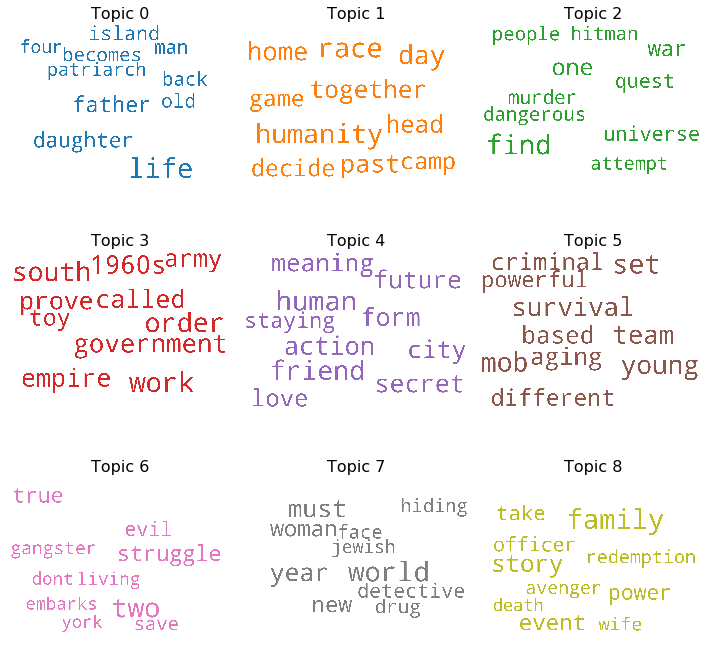

In [146]:
from matplotlib import pyplot as plt
from wordcloud import WordCloud, STOPWORDS
import matplotlib.colors as mcolors

cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = summary_tfidf_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(3, 3, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()